In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
def plotTrainTest(train, test, xaxis = ''):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(train.size)+1, train)
    plt.plot(np.arange(test.size)+1, test)
    plt.title("Test error and train error")
    plt.ylabel("R2 score");  
    plt.xlabel(xaxis);    

Este notebook tem como intenção implementar formas de agrupamentos para algoritmos Machine Learning, e usar uma demonstração simples para ilustrar como estas técnicas afetam o classificador. Escolhi o problema de regressão, pela maior facilidade em programar, e o algoritmo árvore de decisão, porque é um algoritmo em que o tradeoff entre viés e variância do classificador é claro. Por simplicidade, o único hiperparâmetro da árvore usado como variável foi a profundidade máxima. \
\
As duas técnicas escolhidas foram bagging e gradient boosting. \
\
Para facilitar a demonstração, foi usado um conjunto de dados aberto da biblioteca sklearn, com preços de propriedade em Boston, contendo uma amostra de tamanho 506, com 13 features além do alvo (o preço).

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X = data['data']
y = data['target']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(506, 13)

## Decision tree 

In [4]:
from sklearn.tree import DecisionTreeRegressor

O gráfico abaixo mostra o modelo de árvore de decisão com diferentes profundidades máximas. No início, o alto erro corresponde a alto viés (isso pode ser notado porque o erro é alto até no conjunto de treinamento). Com o aumento da profundidade, árvore de decisão tende a sofrer overfit. Isso explica a pequena queda de desempenho no conjunto de teste.

Melhor score no conjunto de teste: 0.8032044307931132


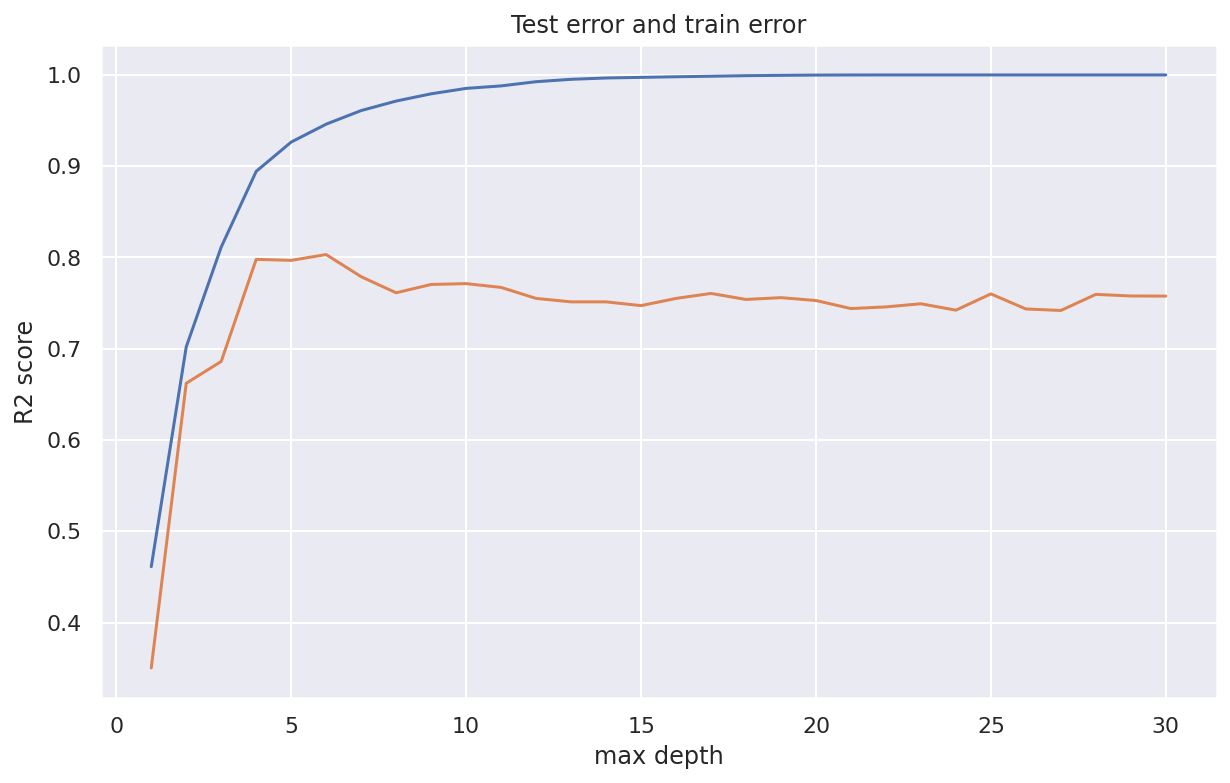

In [27]:
v = np.arange(30) +1
l = len(v)
test = np.zeros(l)
train = np.zeros(l)

for i in np.arange(l):
    test[i] = DecisionTreeRegressor(max_depth=v[i]).fit(X_train, y_train).score(X_test, y_test)
    train[i] = DecisionTreeRegressor(max_depth=v[i]).fit(X_train, y_train).score(X_train, y_train)

plotTrainTest(train, test, 'max depth')
print ('Melhor score no conjunto de teste:', test.max())

## Gradient Boosting

Boosting é uma técnica de agrupamento que permite diminuir o viés de classificadores e regressores. Pode ser usado como base um algoritmo altamente enviesado (como uma árvore de decisão de baixa profundidade) e atingir 100% de precisão no conjunto de treinamento. Como árvores de decisão de pouca profundidade têm pouca variância, isso permite a construção de um regressor de alto desempenho, já que Gradient Boosting é resistente a aumentar variância.

#### É conveniente implementar o método de argrupamento como uma classe:

In [29]:
# boosted tree simples, com apenas três parâmetros. as árvoes individuais foram usadas do sklearn

class boostedTree:
    
    def __init__(self, step_size, iterations, depth):
        self.Trees = []
        self.step_size = step_size
        self.iterations = iterations
        self.depth = depth
        
    #faz uma previsão, que é a soma da previsão de todas as árvores multiplicado pela constante de aprendizado
    def predict(self, X):
        p = []
        [p.append(self.Trees[i].predict(X)) for i in np.arange(len(self.Trees))]
        p = np.array(p)
        return p.sum(axis=0)*self.step_size
    
    #calcula o conjunto de árvores com base num conjunto de dados
    def fit(self, X, y):
        
        tree = DecisionTreeRegressor(max_depth= self.depth)
        self.Trees.append(tree.fit(X,y))
    
        for i in np.arange(self.iterations):
            tree = DecisionTreeRegressor(max_depth= self.depth, random_state=i)
            y_ = y - self.predict(X)
            self.Trees.append(tree.fit(X, y_))
            
        return self
    
            
    def r2Score(self, X, y):
        y_ = self.predict(X)
        return np.absolute(1 - np.var(y-y_)/np.var(y))
    
    def MSE(self, X, y):
        return np.sum((y - self.predict(X))**2)/y.size
        

Agora o cálculo com alguns diferentes valores de taxa de aprendizado. Para não demorar muito para rodar, o número de iterações de cada fit foi ajustado de acordo com a taxa de aprendizado. A tendência de Gradient Boosting é ter problemas de variância com taxas de aprendizados baixas, mas isso não ocorreu na região demonstrada com estes dados.

Melhor score no conjunto de teste: 0.8929831991966115


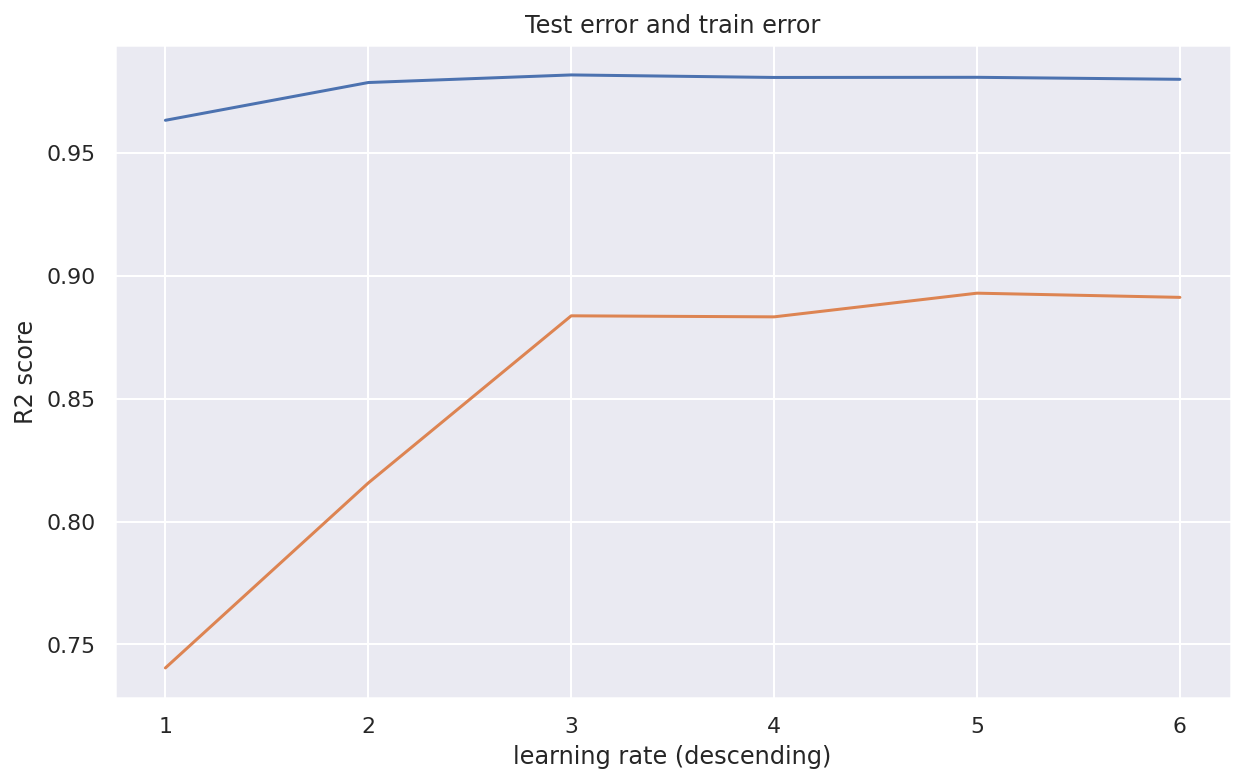

In [36]:
v = [1, 0.7, 0.3, 0.1, 0.05, 0.03]
test = np.zeros(len(v))
train = np.zeros(len(v))

for i in np.arange(len(v)):
    test[i] = boostedTree(step_size = v[i], iterations = int(10/v[i]), depth = 3) \
    .fit(X_train, y_train) \
    .r2Score(X_test, y_test)
    
    train[i] = boostedTree(step_size = v[i], iterations = int(10/v[i]), depth = 3) \
    .fit(X_train, y_train) \
    .r2Score(X_train, y_train) \
    
plotTrainTest(train,test, 'learning rate (descending)')
print ('Melhor score no conjunto de teste:', test.max())

Agora, testando diferentes valores de profundidade das árvores. O aumento da profundidade em Decision Trees causa aumento da variância do algoritmo. Gradient boosting é uma técnica que adereçar viés, e não variância. A queda de desempenho para profundidades grandes notada abaixo é atribuída a isso.

Melhor score no conjunto de teste: 0.8841845567370129


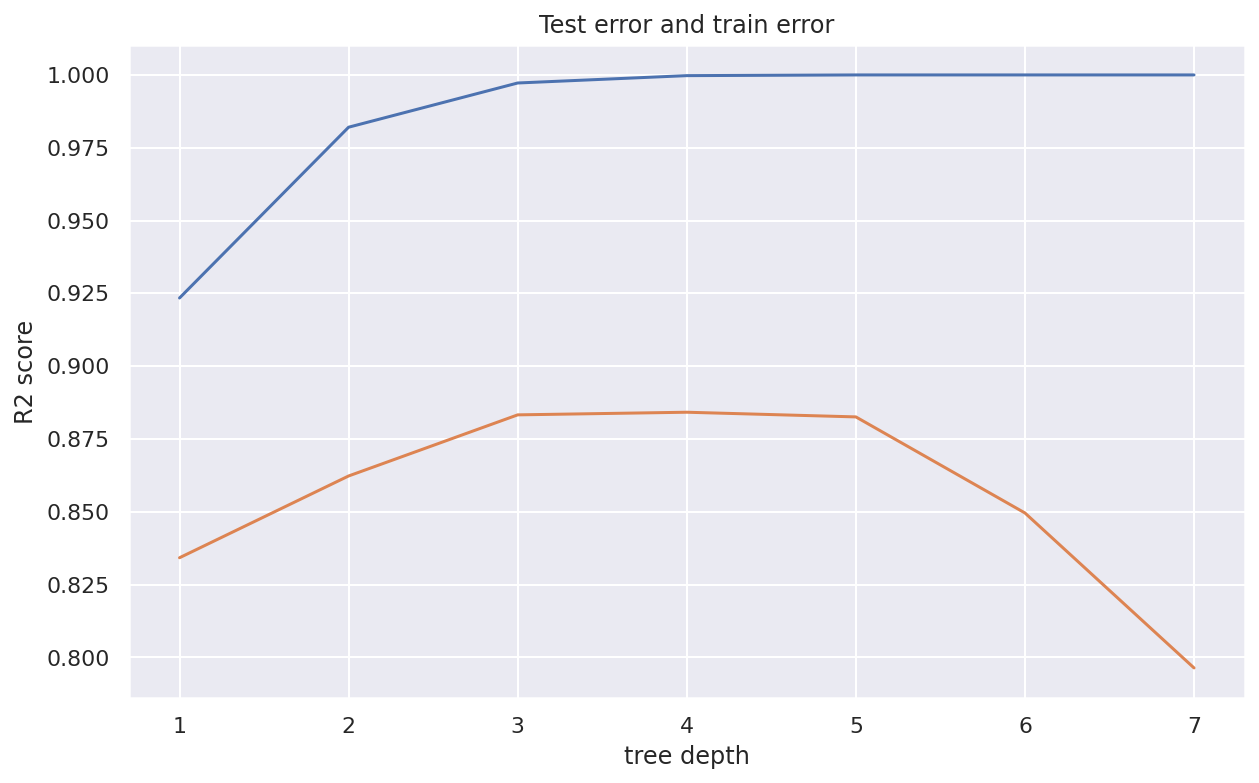

In [60]:
v = [1, 2, 3, 4, 6, 9, 15]

l = len(v)
test = np.zeros(l)
train = np.zeros(l)

for i in np.arange(l):
    test[i] = boostedTree(step_size = 0.1, iterations = 300, depth = v[i]) \
    .fit(X_train, y_train) \
    .r2Score(X_test, y_test)
    
    train[i] = boostedTree(step_size = 0.1, iterations = 300, depth = v[i]) \
    .fit(X_train, y_train) \
    .r2Score(X_train, y_train)
    
plotTrainTest(train,test, 'tree depth')
print ('Melhor score no conjunto de teste:', test.max())

## Bagging (Random Forest)

Bagging consiste de aplicar a técnica estatística Bootstrap para algoritmos Machine Learning. Em vez de treinar apenas um regressor com o conjunto de dados, cria-se diferentes amostras destes dados com reposição e treina-se regressores a cada um desses conjuntos. A ideia é que, como há certa independência entre estes conjuntos (neste caso, porque os dados são diferentes e porque as features usadas a cada árvore também são), o desempenho da média dos estimadores é um estimador melhor (com menor variância). 

In [10]:
# boosted tree simples, com apenas três parâmetros. as árvoes individuais foram usadas do sklearn

class bagging:
    
    def __init__(self, n_samples, max_features):
        self.Classifiers = []
        self.n_samples = n_samples
        self.max_features = max_features
        
    #calcula a previsão do algoritmo, que é a soma da previsão de todas as árvores dividido pelo número total de árvores
    def predict(self, X):
        p = []
        [p.append(self.Classifiers[i].predict(X)) for i in np.arange(self.n_samples)]
        p = np.array(p)
        return p.sum(axis=0)/self.n_samples
    
    
    #calcula o conjunto de árvores
    def fit(self, X, y):        
        for i in np.arange(self.n_samples):
            np.random.seed(i)
            indices = np.random.randint(0, y.size, y.size)
            tree = DecisionTreeRegressor(max_features=self.max_features).fit(X,y)
            self.Classifiers.append(tree)
        return self
    
            
    def r2Score(self, X, y):
        y_ = self.predict(X)
        return np.absolute(1 - np.var(y-y_)/np.var(y))
    
    def MSE(self, X, y):
        return np.sum((y - self.predict(X))**2)/y.size
        

Abaixo, o desempenho do estimador com diferentes número máximo de features em cada árvore individual. Aqui, ocorre o seguinte tradeoff: quanto maior o número de features máximas em cada árvore, melhor o desempenho individual de cada árvore. Mas, ao passo que isso aumenta, diminui a independência entre as diferentes árvores do conjunto (porque as árvores ficam mais parecidas entre si), o que diminui a efetividade de bagging. 

Melhor score no conjunto de teste: 0.887405618493171


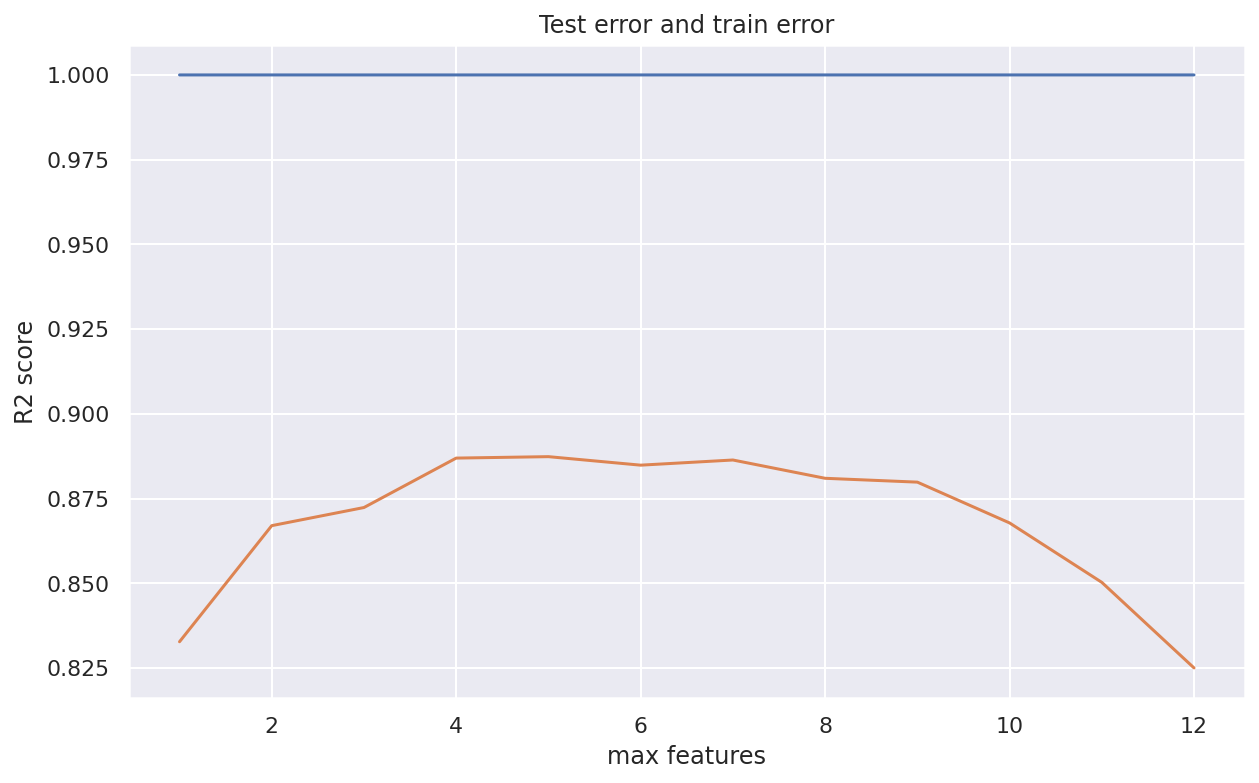

In [9]:
v = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
l = len(v)
test = np.zeros(l)
train = np.zeros(l)

for i in np.arange(l):
    test[i] = bagging(n_samples = 100, max_features = v[i]) \
    .fit(X_train, y_train) \
    .r2Score(X_test, y_test) 
    
    train[i] = bagging(n_samples = 100, max_features = v[i]) \
    .fit(X_train, y_train) \
    .r2Score(X_train, y_train)
    
plotTrainTest(train,test, 'max features')
print ('Melhor score no conjunto de teste:', test.max())

Em geral, o que ocorre é que a qualidade do estimador só melhora com o tamanho do conjunto, porque Bagging não introduz nenhum viés. Apenas existe retorno diminuído, porque há um limite de quanto cada estimador individual no conjunto pode ser independente (dado que o conjunto total de dados e o número de features são limitados).

Melhor score no conjunto de teste: 0.887405618493171


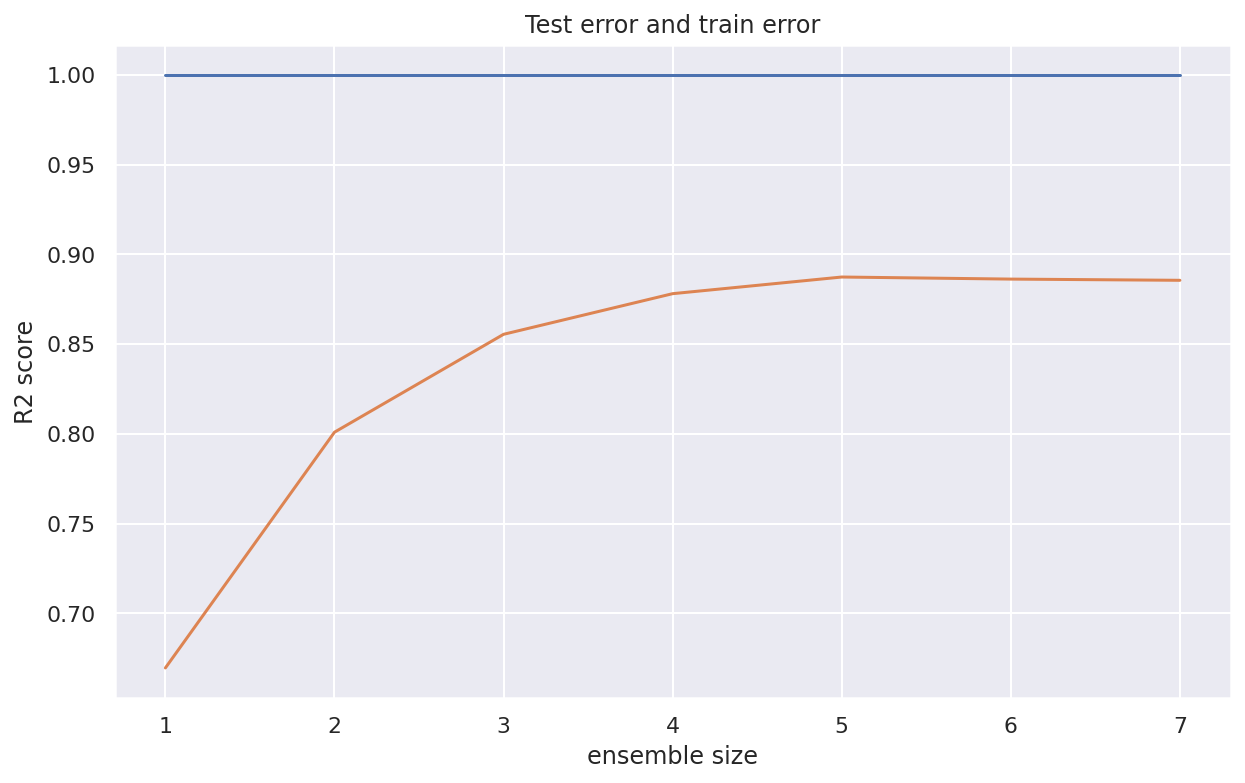

In [57]:
v = [1, 3, 10, 40, 100, 150, 230]
l = len(v)
test = np.zeros(l)
train = np.zeros(l)

for i in np.arange(l):    
    test[i] = bagging(n_samples = v[i], max_features = 5) \
    .fit(X_train, y_train) \
    .r2Score(X_test, y_test) \
    
    train[i] = bagging(n_samples = v[i], max_features = 5) \
    .fit(X_train, y_train) \
    .r2Score(X_train, y_train) \
    
plotTrainTest(train,test, 'ensemble size')
print ('Melhor score no conjunto de teste:', test.max())

## Conclusão

Com Gradient Boosting e Bagging, foi possível aumentar o desempenho do regressor em teste em 8 e 9%, com testes simples, sem muito tuning, manipulando poucos hiperparâmetros. \
\
A flexibilidade de árvores de decisão em conjunto com estas técnicas se dá da seguinte forma: \
\
Árvores de decisão trocam variância por viés de forma simples, em função de, por exemplo, a profundidade máxima. Juntar uma técnica de diminuição de variância (bagging) com árvores de decisão, permite a escolha de árvores individuais de alta variância e pouco viés (profundidade máxima). Ou seja, o problema de viés é resolvido pela escolha de árvore, enquanto o problema da variância é resolvido pelo agrupamento. \
\
Alternativamente, pode-se escolher uma técnica de diminuição de viés (boosting) com árvores de decisão de alto viés e baixa variância (pouco profundas).